## Boilerplate code:

In [1]:
import sys
print(sys.version)

3.11.4 (main, Jul  5 2023, 08:40:20) [Clang 14.0.6 ]


In [2]:
# Typical imports
import numpy as np
%matplotlib inline
from pylab import *
import cv2
import math

In [17]:
# My own helper functions
import julians_little_helpers 
from julians_little_helpers import * 
# For reloading my helper functions when I make changes to them
import importlib
importlib.reload(julians_little_helpers)

# Part 1: Defining Correspondences
For this I chose to use a picture of myself (the photo I took for my student ID lol) and the given photo of George Clooney. 


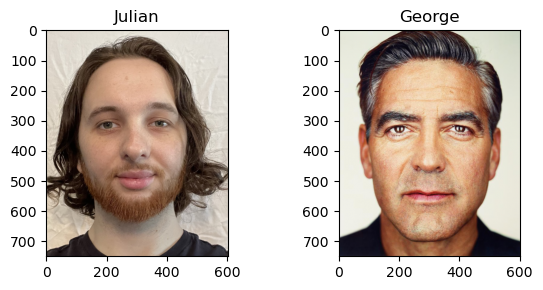

In [19]:
julian = read_im('../data/julian_portrait.jpg')
george = read_im('../data/george.jpg')
Display2Images(julian, george, 'Julian', 'George', 3)

#### Get the points I generated using this website: 
https://inst.eecs.berkeley.edu/~cs194-26/fa22/upload/files/proj3/cs194-26-aex/tool.html

(Thank you to whomever made this!)

In [22]:
# Import the correpsondence data
julian_pts, george_pts = GetPointsFromJSON('../data/julian_portrait_george.json')
print(julian_pts)
print(george_pts)

[[245, 320], [175, 323], [338, 317], [406, 313], [206, 314], [375, 309], [206, 327], [203, 305], [376, 320], [374, 300], [231, 486], [360, 479], [281, 467], [317, 464], [295, 527], [296, 472], [267, 416], [320, 415], [288, 408], [105, 357], [147, 155], [263, 95], [414, 159], [468, 353], [294, 539], [139, 303], [170, 254], [240, 260], [180, 278], [416, 247], [444, 291], [400, 269], [332, 258], [240, 412], [203, 460], [350, 412], [408, 474], [274, 317], [311, 315], [279, 175], [250, 617], [351, 617], [438, 529], [143, 523]]
[[247, 338], [166, 336], [353, 335], [432, 333], [202, 328], [399, 327], [199, 341], [200, 318], [400, 339], [400, 318], [218, 546], [374, 544], [265, 529], [316, 533], [292, 570], [292, 537], [263, 453], [330, 456], [297, 449], [103, 401], [150, 153], [304, 103], [450, 148], [502, 394], [291, 612], [122, 339], [161, 271], [272, 287], [171, 301], [446, 267], [479, 341], [428, 303], [335, 289], [233, 434], [192, 499], [360, 440], [406, 514], [281, 337], [320, 337], [30

#### Get the "mid-way" shape of our faces.
i.e. get the mean of each set of points

In [25]:
midway_pts = []
for i in range(len(julian_pts)):
    mean_point = [julian_pts[i][0] + george_pts[i][0], julian_pts[i][1] + george_pts[i][1]]
    mean_point = [mean_point[0]//2, mean_point[1]//2]
    midway_pts.append(mean_point)
print(midway_pts)

[[246, 329], [170, 329], [345, 326], [419, 323], [204, 321], [387, 318], [202, 334], [201, 311], [388, 329], [387, 309], [224, 516], [367, 511], [273, 498], [316, 498], [293, 548], [294, 504], [265, 434], [325, 435], [292, 428], [104, 379], [148, 154], [283, 99], [432, 153], [485, 373], [292, 575], [130, 321], [165, 262], [256, 273], [175, 289], [431, 257], [461, 316], [414, 286], [333, 273], [236, 423], [197, 479], [355, 426], [407, 494], [277, 327], [315, 326], [289, 184], [244, 655], [358, 651], [458, 545], [134, 542]]


#### Calculate the Delaunay triangulation of the mid-way shape face.

In [ ]:
midway_triangulation = GetDelauynayFromPts(midway_pts)